In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

import os
import matplotlib.pyplot as plt
from skimage.feature import hog
import cv2

In [33]:
def HOG_features(img):

    features = hog(img, orientations=9, pixels_per_cell=(8, 8),
    cells_per_block=(2, 2), visualize=False)

    return features

<b><font size = 5>Multiclass Random Forest (BENIGN, BENIGN_WITHOUT_CALLBACK, MALIGNANT)</font></b>

In [34]:
calc_path = r"D:\VSC Workspace\breast_cancer_CNN\dataset\calcification"
mass_path = r"D:\VSC Workspace\breast_cancer_CNN\dataset\mass"

DIM = 224
def load_and_extract_features(directory, DIM):

    X = []
    y = []

    for label in os.listdir(directory):

        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):

            image_path = os.path.join(label_dir, filename)

            img = cv2.imread(image_path)
            img_resized = cv2.resize(img, (DIM, DIM))
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            hog_features = HOG_features(img_gray)
            
            X.append(hog_features)
            y.append(label)
            
    return X, y

In [35]:
calc_train_X, calc_train_y = load_and_extract_features(calc_path + r"\train\cropped_files", DIM)
calc_test_X, calc_test_y = load_and_extract_features(calc_path + r"\test\cropped_files", DIM)

mass_train_X, mass_train_y = load_and_extract_features(mass_path + r"\train\cropped_files", DIM)
mass_test_X, mass_test_y = load_and_extract_features(mass_path + r"\test\cropped_files", DIM)

<b><font size = 3>Testing for Optimal n_estimators:</b></font>

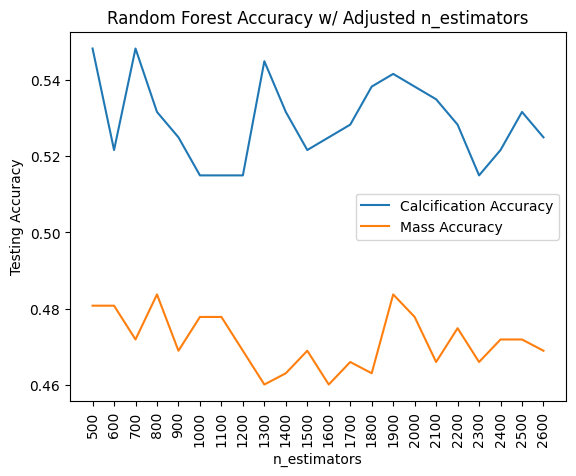

In [36]:
n_estimators = [x for x in range(500, 2700, 100)]
calc_accuracies = []
mass_accuracies = []

for x in n_estimators:

    calc_classifier = RandomForestClassifier(n_estimators = x, criterion='gini', max_depth=5)
    calc_classifier.fit(calc_train_X, calc_train_y)
    calc_predictions = calc_classifier.predict(calc_test_X)
    calc_accuracies.append(accuracy_score(calc_test_y, calc_predictions))


    mass_classifier = RandomForestClassifier(n_estimators = x, criterion='gini', max_depth=5)
    mass_classifier.fit(mass_train_X, mass_train_y)
    mass_predictions = calc_classifier.predict(mass_test_X)
    mass_accuracies.append(accuracy_score(mass_test_y, mass_predictions))

plt.plot(n_estimators, calc_accuracies)
plt.plot(n_estimators, mass_accuracies)
plt.legend(['Calcification Accuracy', 'Mass Accuracy'])
plt.xlabel("n_estimators")
plt.ylabel("Testing Accuracy")
plt.title("Random Forest Accuracy w/ Adjusted n_estimators")
plt.xticks(n_estimators, rotation = 90)
plt.show()

In [37]:
top_calc_accuracies = sorted(zip(calc_accuracies, n_estimators), reverse = True)
opt_nneighbors_calc = top_calc_accuracies[0][1]
print(f"Optimal n_estimators for Calcification Model: {opt_nneighbors_calc}")

top_mass_accuracies = sorted(zip(mass_accuracies, n_estimators), reverse = True)
opt_nneighbors_mass = top_mass_accuracies[0][1]
print(f"Optimal n_estimators for Mass Model: {opt_nneighbors_mass}")

Optimal n_estimators for Calcification Model: 700
Optimal n_estimators for Mass Model: 1900


In [38]:
calc_classifier = RandomForestClassifier(n_estimators = opt_nneighbors_calc, criterion='gini', max_depth=5)
calc_classifier.fit(calc_train_X, calc_train_y)

mass_classifier = RandomForestClassifier(n_estimators = opt_nneighbors_mass, criterion='gini', max_depth=5)
mass_classifier.fit(mass_train_X, mass_train_y)

RandomForestClassifier(max_depth=5, n_estimators=1900)

In [39]:
calc_predictions = calc_classifier.predict(calc_test_X)
calc_confusion = confusion_matrix(calc_test_y, calc_predictions, labels = calc_classifier.classes_)

mass_predictions = calc_classifier.predict(mass_test_X)
mass_confusion = confusion_matrix(mass_test_y, mass_predictions, labels = mass_classifier.classes_)

<b><font size = 3>Multiclass Results:</b></font>

In [40]:
print(f"Calcification Random Forest Model Accuracy: {accuracy_score(calc_test_y, calc_predictions)} \n")
print(classification_report(calc_test_y, calc_predictions))

Calcification Random Forest Model Accuracy: 0.5249169435215947 

                         precision    recall  f1-score   support

                 BENIGN       0.47      0.88      0.61       117
BENIGN_WITHOUT_CALLBACK       0.72      0.51      0.60        67
              MALIGNANT       0.64      0.18      0.28       117

               accuracy                           0.52       301
              macro avg       0.61      0.52      0.50       301
           weighted avg       0.59      0.52      0.48       301



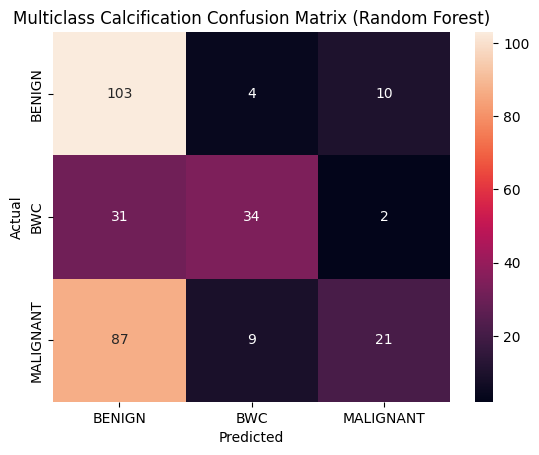

In [41]:
labels = calc_classifier.classes_
labels[1] = "BWC"

sns.heatmap(calc_confusion, annot = True, xticklabels= labels, yticklabels = labels, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Multiclass Calcification Confusion Matrix (Random Forest)")
plt.show()

In [42]:
print(f"Mass Random Forest Model Accuracy: {accuracy_score(mass_test_y, mass_predictions)} \n")
print(classification_report(mass_test_y, mass_predictions))

Mass Random Forest Model Accuracy: 0.4778761061946903 

                         precision    recall  f1-score   support

                 BENIGN       0.49      0.93      0.64       165
BENIGN_WITHOUT_CALLBACK       0.00      0.00      0.00        37
              MALIGNANT       0.36      0.06      0.10       137

               accuracy                           0.48       339
              macro avg       0.28      0.33      0.25       339
           weighted avg       0.38      0.48      0.35       339



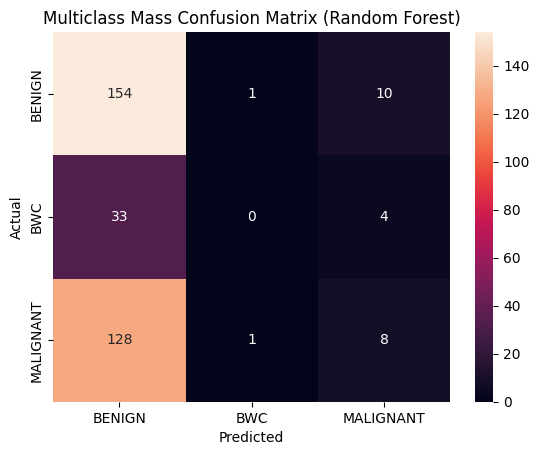

In [43]:
labels = mass_classifier.classes_
labels[1] = "BWC"

sns.heatmap(mass_confusion, annot = True, xticklabels= labels, yticklabels = labels, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Multiclass Mass Confusion Matrix (Random Forest)")
plt.show()

<b><font size = 5>Binary Random Forest (BENIGN, MALIGNANT)</font></b>

In [44]:
calc_path = r"D:\VSC Workspace\breast_cancer_CNN\cropped_dataset\calcification"
mass_path = r"D:\VSC Workspace\breast_cancer_CNN\cropped_dataset\mass"

DIM = 224
def load_and_extract_features(directory, DIM):

    X = []
    y = []

    for label in os.listdir(directory):

        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):

            image_path = os.path.join(label_dir, filename)

            img = cv2.imread(image_path)
            img_resized = cv2.resize(img, (DIM, DIM))
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            hog_features = HOG_features(img_gray)
            
            X.append(hog_features)
            y.append(label)
            
    return X, y

In [45]:
calc_train_X, calc_train_y = load_and_extract_features(calc_path + r"\train", DIM)
calc_test_X, calc_test_y = load_and_extract_features(calc_path + r"\test", DIM)

mass_train_X, mass_train_y = load_and_extract_features(mass_path + r"\train", DIM)
mass_test_X, mass_test_y = load_and_extract_features(mass_path + r"\test", DIM)

<b><font size = 3>Testing for Optimal n_estimators:</b></font>

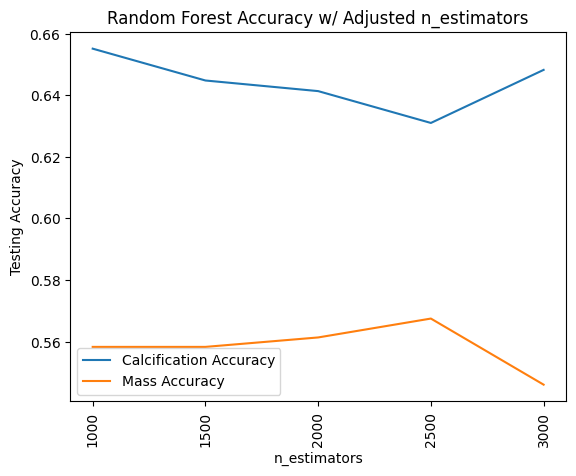

In [46]:
n_estimators = [x for x in range(1000, 3500, 500)]
calc_accuracies = []
mass_accuracies = []

for x in n_estimators:

    calc_classifier = RandomForestClassifier(n_estimators = x, criterion='gini', max_depth=5)
    calc_classifier.fit(calc_train_X, calc_train_y)
    calc_predictions = calc_classifier.predict(calc_test_X)
    calc_accuracies.append(accuracy_score(calc_test_y, calc_predictions))


    mass_classifier = RandomForestClassifier(n_estimators = x, criterion='gini', max_depth=5)
    mass_classifier.fit(mass_train_X, mass_train_y)
    mass_predictions = calc_classifier.predict(mass_test_X)
    mass_accuracies.append(accuracy_score(mass_test_y, mass_predictions))

plt.plot(n_estimators, calc_accuracies)
plt.plot(n_estimators, mass_accuracies)
plt.legend(['Calcification Accuracy', 'Mass Accuracy'])
plt.xlabel("n_estimators")
plt.ylabel("Testing Accuracy")
plt.title("Random Forest Accuracy w/ Adjusted n_estimators")
plt.xticks(n_estimators, rotation = 90)
plt.show()

In [47]:
top_calc_accuracies = sorted(zip(calc_accuracies, n_estimators), reverse = True)
opt_nneighbors_calc = top_calc_accuracies[0][1]
print(f"Optimal n_estimators for Calcification Model: {opt_nneighbors_calc}")

top_mass_accuracies = sorted(zip(mass_accuracies, n_estimators), reverse = True)
opt_nneighbors_mass = top_mass_accuracies[0][1]
print(f"Optimal n_estimators for Mass Model: {opt_nneighbors_mass}")

Optimal n_estimators for Calcification Model: 1000
Optimal n_estimators for Mass Model: 2500


In [48]:
calc_classifier = RandomForestClassifier(n_estimators = opt_nneighbors_calc, criterion='gini', max_depth=5)
calc_classifier.fit(calc_train_X, calc_train_y)

mass_classifier = RandomForestClassifier(n_estimators = opt_nneighbors_mass, criterion='gini', max_depth=5)
mass_classifier.fit(mass_train_X, mass_train_y)

RandomForestClassifier(max_depth=5, n_estimators=2500)

In [49]:
calc_predictions = calc_classifier.predict(calc_test_X)
calc_confusion = confusion_matrix(calc_test_y, calc_predictions)

mass_predictions = calc_classifier.predict(mass_test_X)
mass_confusion = confusion_matrix(mass_test_y, mass_predictions)

<b><font size = 3>Binary Results:</b></font>

In [50]:
print(f"Calcification Random Forest Model Accuracy: {accuracy_score(calc_test_y, calc_predictions)} \n")
print(classification_report(calc_test_y, calc_predictions))

Calcification Random Forest Model Accuracy: 0.6482758620689655 

              precision    recall  f1-score   support

      BENIGN       0.64      0.92      0.76       173
   MALIGNANT       0.68      0.24      0.35       117

    accuracy                           0.65       290
   macro avg       0.66      0.58      0.56       290
weighted avg       0.66      0.65      0.60       290



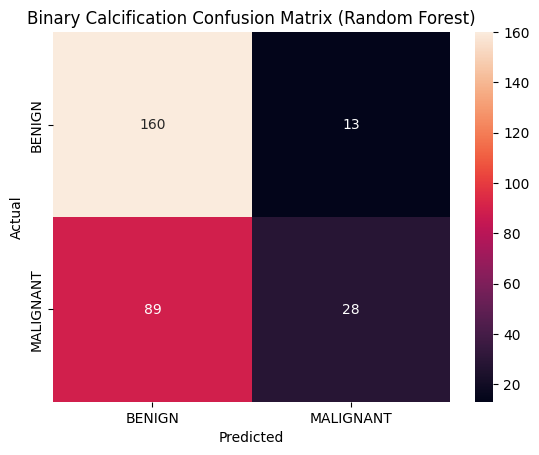

In [51]:
labels = calc_classifier.classes_

sns.heatmap(calc_confusion, annot = True, xticklabels= labels, yticklabels = labels, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Binary Calcification Confusion Matrix (Random Forest)")
plt.show()

In [52]:
print(f"Mass Random Forest Model Accuracy: {accuracy_score(mass_test_y, mass_predictions)} \n")
print(classification_report(mass_test_y, mass_predictions))

Mass Random Forest Model Accuracy: 0.5521472392638037 

              precision    recall  f1-score   support

      BENIGN       0.57      0.88      0.69       189
   MALIGNANT       0.38      0.10      0.16       137

    accuracy                           0.55       326
   macro avg       0.48      0.49      0.43       326
weighted avg       0.49      0.55      0.47       326



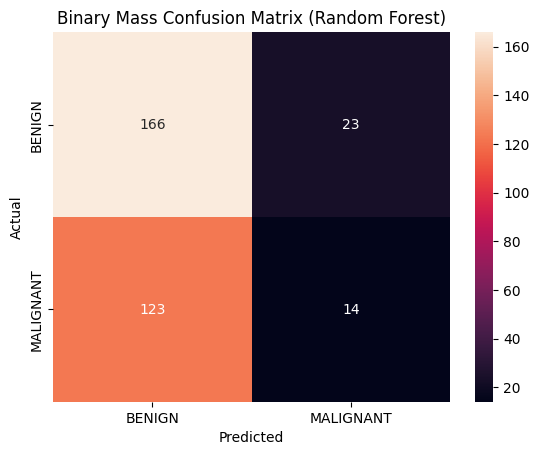

In [53]:
labels = mass_classifier.classes_

sns.heatmap(mass_confusion, annot = True, xticklabels= labels, yticklabels = labels, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Binary Mass Confusion Matrix (Random Forest)")
plt.show()